**Hani Park** (hani.park@uni-potsdam.de)

## Multi-Armed Bandits (MAB) algorithms

Inspired by the Thompson sampling example given in <br>
https://colab.research.google.com/drive/1R5QiVlF6w08dyQmTE6AoBi-TfjOoXcSk#scrollTo=UtWPQQ5BASwf

### Scenario
Imagine that you are at a casino, and that you have \\$1,000 to play the slot machines. There are six slot machines available, and each turn playing a machine costs \\$1. The probability of winning on any given turn (which is called the ***conversion rate***) is unknown, and varies from machine to machine. In order to maximize your chances of winning, you would like to be able to identify the slot machine that has the highest conversion rate as quickly as possible. How can you achieve this goal?

### Import Required Libraries

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')

### Define Environment

In [2]:
#Define the total number of turns (i.e., the number of times we will play a slot machine).
#Remember, we have $1,000 available, and each turn costs $1. We thus have 1,000 turns.
number_of_turns = 1000

#define the total number of slot machines
number_of_slot_machines = 6

#define a seed for the random number generator (to ensure that results are reproducible)
np.random.seed(33)

#create a random conversion rate between 1% and 15% for each slot machine
conversion_rates = np.random.uniform(0.05, 0.18, number_of_slot_machines)
conversion_rates[5]=0.01
#Show conversion rates for each slot machine. Remember that in a real-world scenario
#the decision-maker would not know this information!
for i in range(6):
    print('Conversion rate for slot machine {0}: {1:.2%}'.format(i, conversion_rates[i]))

Conversion rate for slot machine 0: 8.23%
Conversion rate for slot machine 1: 10.85%
Conversion rate for slot machine 2: 10.34%
Conversion rate for slot machine 3: 8.38%
Conversion rate for slot machine 4: 16.32%
Conversion rate for slot machine 5: 1.00%


### Create the Data Set

In [3]:
def gen_dataset(random_seed=50):
    np.random.seed(random_seed)

    ''' The data set is a matrix with one row for each turn, 
    and one column for each slot machine.
    Each item in the matrix represents the outcome of what would happen 
    if we were to play a particular slot machine on that particular turn. 
    A value of "1" indicates that we would win, 
    while a value of "0" indicates that we would lose. 
    The number of "wins" for each slot machine is determined by its conversion rate. '''
    outcomes = np.zeros((number_of_turns, number_of_slot_machines))   
    
    for turn_index in range(number_of_turns): #for each turn
        for slot_machine_index in range(number_of_slot_machines): #for each slot machine
            ''' Get a random number between 0.0 and 1.0.
            If the random number is less than or equal to this slot machine's conversion rate, 
            then set the outcome to "1".
            Otherwise, the outcome will be "0" 
            because the entire matrix was initially filled with zeros. '''
            if np.random.rand() <= conversion_rates[slot_machine_index]:
                outcomes[turn_index][slot_machine_index] = 1

    return outcomes

In [4]:
outcomes = gen_dataset()

# display the first 15 rows of data
''' this sort of indexing means "rows 0 to 14" (i.e., the first 15 rows) 
and "columns 0 through 5" (i.e., the first six columns) '''
print(outcomes[0:15, 0:6]) 

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [5]:
#show means (i.e., conversion rates) for each column (i.e., for each slot machine)
for i in range(6):
    print('Mean for column {0}: {1:.2%}'.format(i, np.mean(outcomes[:, i])))

Mean for column 0: 7.60%
Mean for column 1: 11.10%
Mean for column 2: 9.00%
Mean for column 3: 10.30%
Mean for column 4: 15.90%
Mean for column 5: 0.50%


In [6]:
optimal_slot_machine_index = np.argwhere(
    conversion_rates == max(conversion_rates)).flatten()[0]
print('Optimal slot machine: {}'.format(optimal_slot_machine_index))

Optimal slot machine: 4


### Helper Functions

In [7]:
def get_statistics(history_reward, history_action,
                  print_statistics=False):

    optimal_values = number_of_turns*[np.max(conversion_rates)]
    actual_values = [conversion_rates[idx] for idx in history_action]
    paired_values = zip(optimal_values, actual_values)
    difference = []
    for optimal_value, actual_value in paired_values:
        difference.append(optimal_value-actual_value)
    regret = np.sum(difference)
    regret_cumsum = np.cumsum(difference)
    
    total_reward = np.sum(history_reward)
    if print_statistics:
        for action in range(number_of_slot_machines):
            print("slot machine {} was played {} times.".format(
                action, history_action.count(action)))
        print('total regret: ', np.round(regret, 2))
        print('total reward: ', total_reward)

    return regret_cumsum, regret, total_reward


def repeat_experiments(Policy, params=None, n_experiments=1000):
    total_regret_list = []
    total_reward_list = []
    
    for seed in range(n_experiments):
        dataset = gen_dataset(random_seed = seed)
        policy = Policy()  # initialize the corresponding policy class
        
        history_reward, history_action = policy.simulate(dataset)
        _, total_regret, total_reward = get_statistics(history_reward, history_action)
        total_regret_list.append(total_regret)
        total_reward_list.append(total_reward)
    
    stats = {}
    stats['policy'] = policy.name
    stats['total_regret'] = np.round(np.mean(total_regret_list), 2)
    stats['min_regret'] = np.round(np.min(total_regret_list), 2)
    stats['max_regret'] = np.round(np.max(total_regret_list), 2)
    stats['var_regret'] = np.round(np.var(total_regret_list), 2)
    stats['total_reward'] = np.round(np.mean(total_reward_list), 2)
    
    print('===== ' + policy.name + ' =====')
    print('Average total regret: {},  Average total reward: {}'.format(
        stats['total_regret'],  stats['total_reward']))
    print('Minimum regret: {}, Maximum regret: {}, variance of regret: {}'.format(
        stats['min_regret'], stats['max_regret'], stats['var_regret']))
          
    return total_regret_list, stats


def plot_regret_distribution(regrets):
    sns.set(rc={'figure.figsize':(15,4)})
    sns.histplot(regrets, element="step", fill=False)
    plt.xlabel('Total Regret')
    plt.title('Distribution of Total Regrets over ' + str(len(regrets)) + ' experiments')
    
def plot_regret_growth(regret_cumsum):
    sns.set(rc={'figure.figsize':(15,4)})
    sns.lineplot(x=range(1, number_of_turns+1), y=regret_cumsum)
    plt.xlabel('Number of trials')
    plt.ylabel('Cumulative Regret')
    plt.title('Regret Growth over ' + str(number_of_turns) + ' trials')

### Thompson Sampling  Algorithm

In [8]:
class ThompsonSampling:
    
    def __init__(self):
        self.name = 'Thompson Sampling'
        self.n_actions = number_of_slot_machines
        self.history_reward = []
        self.history_action = []
        
        # Define arrays where we can keep track of our wins (positive rewards) 
        # and losses (negative rewards) for each slot machine.
        self.number_of_positive_rewards = np.ones(number_of_slot_machines)
        self.number_of_negative_rewards = np.ones(number_of_slot_machines)
    
    def take_action(self):

        index_of_machine_to_play = -1
        max_beta = -1
        
        # determine which slot machine to play for this turn ''' 
        for slot_machine_index in range(number_of_slot_machines): #for each slot machine
            
            # Define the parameters for the beta distribution. 
            # The shape will depend on the number of wins and losses 
            # that have thus far been observed for this particular slot machine.
            a = self.number_of_positive_rewards[slot_machine_index]
            b = self.number_of_negative_rewards[slot_machine_index]
           
            # Get a random value from the beta distribution whose shape is defined by 
            # the number of wins and losses that have been observed so far
            random_beta = np.random.beta(a, b)

            # Determine the largest beta value thus far observed 
            if random_beta > max_beta:
                # update the maximum beta value thus far observed
                max_beta = random_beta 
                # set the machine to play to the current machine
                index_of_machine_to_play = slot_machine_index 

        return index_of_machine_to_play
    
    
    def simulate(self, dataset):

        for trial in range(number_of_turns):   
            
            # play the selected slot machine, and record whether we win or lose
            action = self.take_action()  # take an action
            reward = dataset[trial][action]   # observe the received reward
            if reward == 1:
                self.number_of_positive_rewards[action] += 1
            else:
                self.number_of_negative_rewards[action] += 1
            
            self.history_reward.append(reward)
            self.history_action.append(action)
            
        return self.history_reward, self.history_action

slot machine 0 was played 121 times.
slot machine 1 was played 273 times.
slot machine 2 was played 32 times.
slot machine 3 was played 169 times.
slot machine 4 was played 374 times.
slot machine 5 was played 31 times.
total regret:  44.77
total reward:  113.0


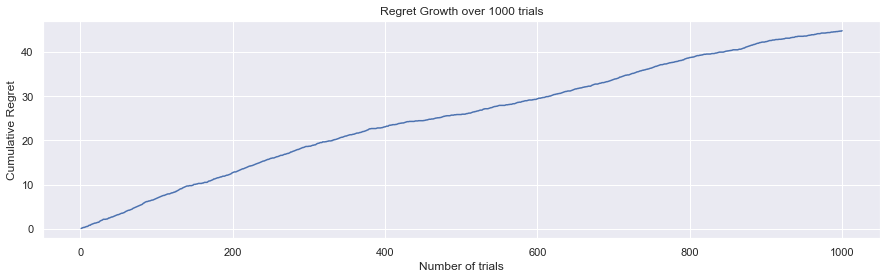

In [9]:
rewards, actions = ThompsonSampling().simulate(outcomes)
regrets_cumsum, _, _ = get_statistics(rewards, actions, print_statistics=True)
plot_regret_growth(regrets_cumsum)

===== Thompson Sampling =====
Average total regret: 32.48,  Average total reward: 130.36
Minimum regret: 13.92, Maximum regret: 71.9, variance of regret: 106.03


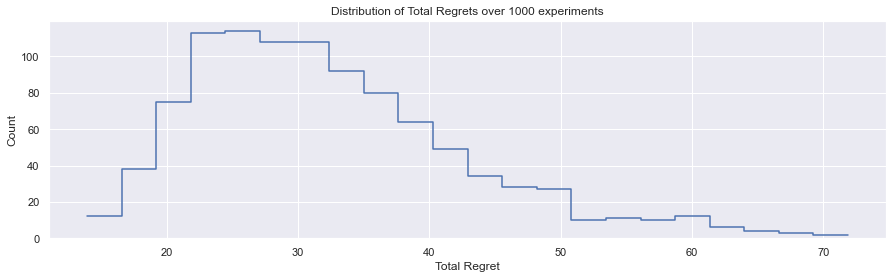

In [10]:
thompson_sampling_regrets, thompson_sampling_stats = repeat_experiments(ThompsonSampling)
plot_regret_distribution(thompson_sampling_regrets)

### UCB1  Algorithm

In [11]:
class UCB1:
    
    def __init__(self, c=0.2):
        self.name = 'UCB1 with c=' + str(c)
        self.n_actions = number_of_slot_machines
        self.history_reward = []
        self.history_action = []
        
        self.Q = np.zeros(number_of_slot_machines)
        self.c = c
        self.N = 0
        self.N_action = np.zeros(number_of_slot_machines)
        
        self.number_of_positive_rewards = np.zeros(number_of_slot_machines)
        self.number_of_negative_rewards = np.zeros(number_of_slot_machines)
    
    
    def take_action(self):
        max_UCB = -np.inf
        action_to_take = -np.inf
        
        # Play each machine once in the beginning
        if self.N in range(number_of_slot_machines):
            action_to_take = self.N
            return action_to_take
                
        for action in range(number_of_slot_machines):
            exploration_bonus = self.c * np.sqrt( 2*np.log(self.N) / self.N_action[action] )
            self.Q[action] = self.number_of_positive_rewards[action]/self.N_action[action]
            UCB = self.Q[action] + exploration_bonus

            if UCB > max_UCB:
                max_UCB = UCB
                action_to_take = action

        return action_to_take
    
    
    def simulate(self, dataset):
        
        # Determin the action to be taken.
        for trial in range(number_of_turns):  
            action = self.take_action()  # take an action
    
            # Record whether we win or lose
            reward = dataset[trial][action]   # observe the received reward
            if reward == 1:
                self.number_of_positive_rewards[action] += 1
            else:
                self.number_of_negative_rewards[action] += 1
            
            self.history_reward.append(reward)
            self.history_action.append(action)
            self.N_action[action] += 1
            self.N += 1 
            
        return self.history_reward, self.history_action

slot machine 0 was played 127 times.
slot machine 1 was played 217 times.
slot machine 2 was played 127 times.
slot machine 3 was played 178 times.
slot machine 4 was played 258 times.
slot machine 5 was played 93 times.
total regret:  58.07
total reward:  102.0


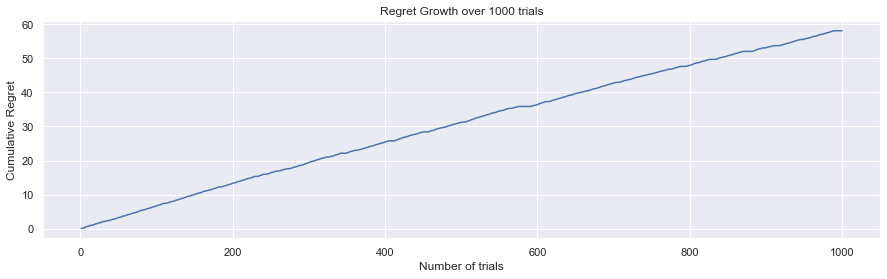

In [12]:
rewards, actions = UCB1(c=1.0).simulate(outcomes)
regrets_cumsum, _, _ = get_statistics(rewards, actions, print_statistics=True)
plot_regret_growth(regrets_cumsum)

<font color=purple> UCB1 does not show sublinear regret growth with c=1, which was given by the exercise sheet. <br>
Thus, I changed with the different values for the hyperparameter c, and I found out that c=0.2 shows the better performance in our problem. 

slot machine 0 was played 43 times.
slot machine 1 was played 43 times.
slot machine 2 was played 51 times.
slot machine 3 was played 27 times.
slot machine 4 was played 819 times.
slot machine 5 was played 17 times.
total regret:  13.62
total reward:  144.0


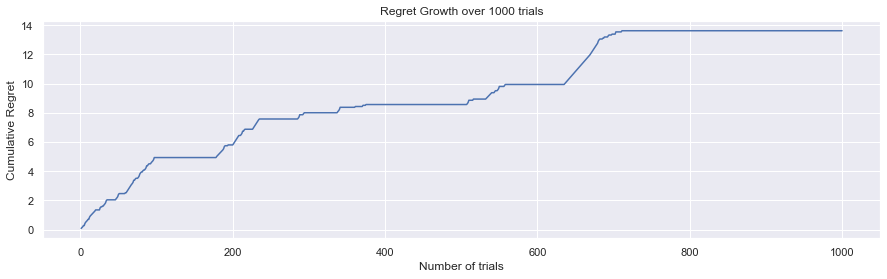

In [13]:
rewards, actions = UCB1(c=0.2).simulate(outcomes)
regrets_cumsum, _, _ = get_statistics(rewards, actions, print_statistics=True)
plot_regret_growth(regrets_cumsum)

===== UCB1 with c=0.2 =====
Average total regret: 23.62,  Average total reward: 139.36
Minimum regret: 7.13, Maximum regret: 71.01, variance of regret: 153.04


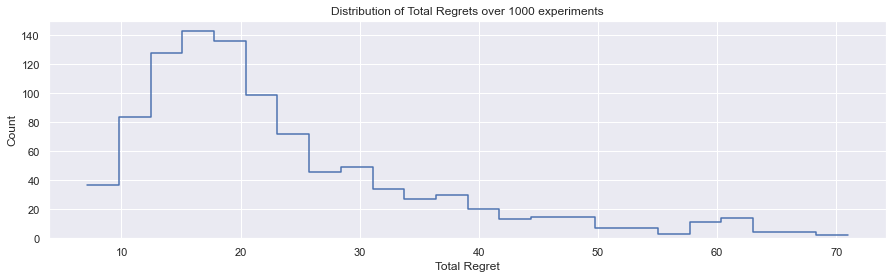

In [14]:
UCB1_regrets, UCB1_stats = repeat_experiments(UCB1)
plot_regret_distribution(UCB1_regrets)

### UCB2  Algorithm

In [15]:
class UCB2:
    
    def __init__(self, alpha=0.15):
        self.name = 'UCB2 with alpha=' + str(alpha) 
        self.n_actions = number_of_slot_machines
        self.history_reward = []
        self.history_action = []
        
        self.alpha = alpha
        self.r = np.zeros(number_of_slot_machines)
        self.Q = np.zeros(number_of_slot_machines)
        self.N = 0
        self.N_action = np.zeros(number_of_slot_machines)
        self.action_to_try = -1
        self.times_to_try = 0
        
        self.number_of_positive_rewards = np.zeros(number_of_slot_machines)
        self.number_of_negative_rewards = np.zeros(number_of_slot_machines)
    
    
    def take_action(self):
        max_UCB = -np.inf
        action_to_take = -np.inf
        
        # Play each machine once in the beginning
        if self.N in range(number_of_slot_machines):
            self.action_to_try = self.N
            return self.action_to_try
        elif self.times_to_try > 0:
            self.times_to_try -= 1
            return self.action_to_try
        else:
            for action in range(number_of_slot_machines):
                tau = int(np.ceil((1 + self.alpha) ** self.r[action]))
                exploration_bonus = \
                    np.sqrt((1 + self.alpha) * np.log((np.e*self.N)/tau) / (2*tau))
                self.Q[action] = self.number_of_positive_rewards[action]/self.N_action[action]
                UCB = self.Q[action] + exploration_bonus

                if UCB > max_UCB:
                    max_UCB = UCB
                    self.action_to_try = action

            tau_first = int(np.ceil((1 + self.alpha) ** (self.r[self.action_to_try]+1)))
            tau_second = int(np.ceil((1 + self.alpha) ** self.r[self.action_to_try]))
            self.times_to_try = tau_first - tau_second
            self.times_to_try -= 1   # because it will be already taken once
            self.r[self.action_to_try] += 1

        return self.action_to_try
    
    
    def simulate(self, dataset):
        
        # Determin the action to be taken.
        for trial in range(number_of_turns):  
            action = self.take_action()  # take an action
    
            # Record whether we win or lose
            reward = dataset[trial][action]   # observe the received reward
            if reward == 1:
                self.number_of_positive_rewards[action] += 1
            else:
                self.number_of_negative_rewards[action] += 1
            
            self.history_reward.append(reward)
            self.history_action.append(action)
            self.N_action[action] += 1
            self.N += 1 
            
        return self.history_reward, self.history_action

slot machine 0 was played 108 times.
slot machine 1 was played 84 times.
slot machine 2 was played 95 times.
slot machine 3 was played 141 times.
slot machine 4 was played 514 times.
slot machine 5 was played 58 times.
total regret:  39.06
total reward:  126.0


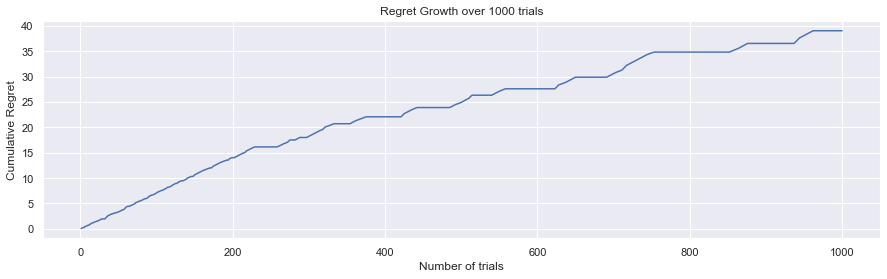

In [16]:
rewards, actions = UCB2().simulate(outcomes)
regrets_cumsum, _, _ = get_statistics(rewards, actions, print_statistics=True)
plot_regret_growth(regrets_cumsum)

===== UCB2 with alpha=0.15 =====
Average total regret: 46.36,  Average total reward: 116.64
Minimum regret: 28.12, Maximum regret: 65.7, variance of regret: 37.93


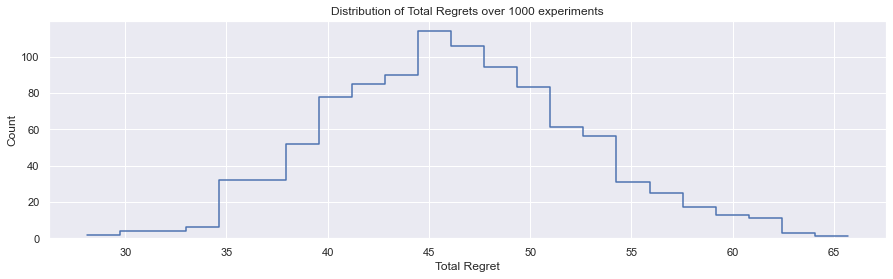

In [17]:
UCB2_regrets, UCB2_stats = repeat_experiments(UCB2)
plot_regret_distribution(UCB2_regrets)

### $\epsilon_n$ - Greedy  Algorithm

In [18]:
class Decaying_Epsilon_Greedy:
    
    def __init__(self, c=0.05):
        self.name = 'Decaying Epsilon Greedy with c=' + str(c)
        self.n_actions = number_of_slot_machines
        self.history_reward = []
        self.history_reward_per_action = {}
        for action_idx in range(self.n_actions):
            self.history_reward_per_action[action_idx] = []
        self.history_action = []
        
        conversion_rates_without_max = np.delete(conversion_rates, np.argmax(conversion_rates))
        self.d = np.max(conversion_rates) - np.max(conversion_rates_without_max)
        self.c = c
        self.N = 1
        self.epsilon = min(1, (self.c*self.n_actions)/((self.d**2)*self.N))
    
    
    def take_action(self):
        mean_reward_list = []
        
        for action in range(self.n_actions):
        
            ''' The arm that has never been selected must be prioritized '''
            if not len(self.history_reward_per_action[action]) > 0:
                return action 
            
            ''' iteratively compute the impirical mean of each arm'''
            mean_rewards = np.mean(self.history_reward_per_action[action])
            mean_reward_list.append(mean_rewards)
        
        ''' the case where there are multiple arms that have the highest mean reward '''
        action_argmax_list = np.argwhere(mean_reward_list == np.max(mean_reward_list))
        action_argmax = np.random.choice(action_argmax_list.flatten()) 
        
        self.epsilon = min(1, (self.c*self.n_actions)/((self.d**2)*self.N))
        r = np.random.uniform(0, 1)
        if r < self.epsilon:
            self.action_to_try = np.random.randint(0, number_of_slot_machines)
        else:
            self.action_to_try = action_argmax

        return self.action_to_try
    
    
    def simulate(self, dataset):
        for trial in range(number_of_turns):   
            action = self.take_action()  # take an action
            reward = dataset[trial][action]   # observe the received reward
            self.history_reward.append(reward)
            self.history_reward_per_action[action].append(reward)
            self.history_action.append(action)
            self.N += 1
            
        return self.history_reward, self.history_action

slot machine 0 was played 85 times.
slot machine 1 was played 97 times.
slot machine 2 was played 222 times.
slot machine 3 was played 68 times.
slot machine 4 was played 469 times.
slot machine 5 was played 59 times.
total regret:  39.86
total reward:  126.0


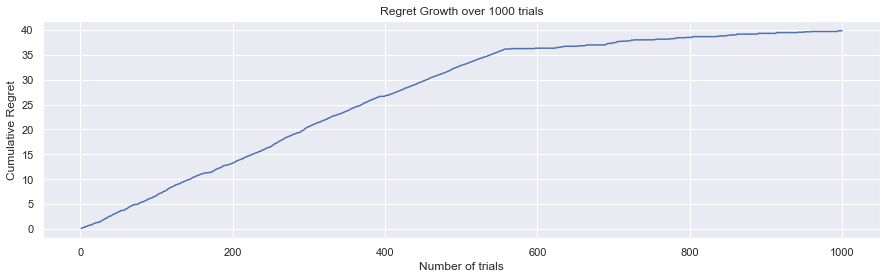

In [19]:
rewards, actions  = Decaying_Epsilon_Greedy().simulate(outcomes)
regrets_cumsum, _, _ = get_statistics(rewards, actions, print_statistics=True)
plot_regret_growth(regrets_cumsum)

===== Decaying Epsilon Greedy with c=0.05 =====
Average total regret: 33.11,  Average total reward: 129.6
Minimum regret: 19.93, Maximum regret: 77.4, variance of regret: 198.64


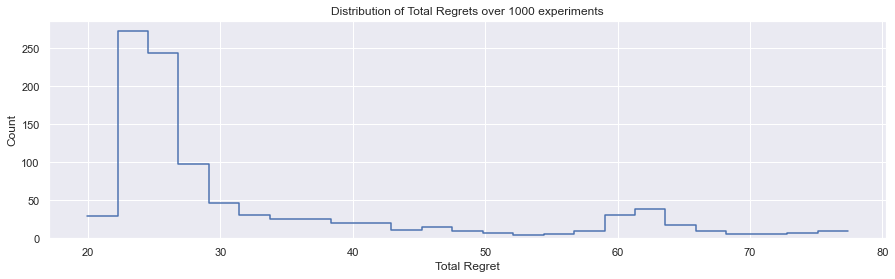

In [20]:
decaying_e_greedy_regrets, decaying_e_greedy_stats = repeat_experiments(Decaying_Epsilon_Greedy)
plot_regret_distribution(decaying_e_greedy_regrets)

### Compare the Performance of Multi-Armed Bandits Algorithms

In [21]:
pd.concat([
    pd.DataFrame([thompson_sampling_stats]),
    pd.DataFrame([UCB1_stats]),
    pd.DataFrame([UCB2_stats]),
    pd.DataFrame.from_dict([decaying_e_greedy_stats])
], ignore_index=True)

,policy,total_regret,min_regret,max_regret,var_regret,total_reward
0,Thompson Sampling,32.48,13.92,71.90,106.03,130.36
1,UCB1 with c=0.2,23.62,7.13,71.01,153.04,139.36
2,UCB2 with alpha=0.15,46.36,28.12,65.70,37.93,116.64
3,Decaying Epsilon Greedy with c=0.05,33.11,19.93,77.40,198.64,129.60


##### Findings

- <Font color=purple> Note that I have already tweaked the hyperparameters in each algorithm and picked the best one. 
- Thompson Sampling is the only one that does not require hyperparameters. 
- Although Thompson Sampling is the oldest Exploration-Exploitation balancing algorithm, it is still one of those that works pretty well in practice. <br>
- UCB1 with c=0.2 shows the best performance in our specific problem. 
- UCB2 with $\alpha$ = 0.15 suffers from regrets the most, however, it has the lowest variance of total regrets over multiple experiments. 
- Decaying Epsilon-greedy can be viewed as pure exploration, and thus it shows high variance. <br>
- Decaying Epsilon-greedy requires the knowledge of the gaps between the optimal action value and the suboptimal action value in advance. 